In [1]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

# Loading our dataset

In [2]:
data = pd.read_csv('BTC.csv')
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Nov 08, 2022","18,527.4","20,589.0","20,667.5","17,260.0",865.10K,-10.01%
1,"Nov 07, 2022","20,589.0","20,916.3","21,055.4","20,410.5",414.24K,-1.56%
2,"Nov 06, 2022","20,916.3","21,298.7","21,360.4","20,901.0",242.26K,-1.81%
3,"Nov 05, 2022","21,301.6","21,145.7","21,464.7","21,084.1",261.23K,0.74%
4,"Nov 04, 2022","21,145.9","20,206.4","21,281.9","20,184.6",499.50K,4.65%


In [3]:
data.dropna(inplace=True)

In [4]:
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['Open'] = pd.to_numeric(data['Open'])

In [5]:
data['High'] = data['High'].str.replace(',', '').astype(float)
data['High'] = pd.to_numeric(data['High'])

In [6]:
data['Low'] = data['Low'].str.replace(',', '').astype(float)
data['Low'] = pd.to_numeric(data['Low'])

In [7]:
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Price'] = pd.to_numeric(data['Price'])

In [8]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,"Nov 08, 2022",18527.4,20589.0,20667.5,17260.0,865.10K,-10.01%
1,"Nov 07, 2022",20589.0,20916.3,21055.4,20410.5,414.24K,-1.56%
2,"Nov 06, 2022",20916.3,21298.7,21360.4,20901.0,242.26K,-1.81%
3,"Nov 05, 2022",21301.6,21145.7,21464.7,21084.1,261.23K,0.74%
4,"Nov 04, 2022",21145.9,20206.4,21281.9,20184.6,499.50K,4.65%
...,...,...,...,...,...,...,...
665,"Jan 12, 2021",34076.1,35426.0,36598.7,32572.7,241.93K,-4.13%
666,"Jan 11, 2021",35544.3,38195.3,38217.2,30411.6,251.04K,-6.93%
667,"Jan 10, 2021",38192.2,40149.7,41362.4,35141.6,215.78K,-4.88%
668,"Jan 09, 2021",40151.9,40607.2,41363.5,38775.1,128.42K,-1.10%


# Building a baseline model that will be compared to our HMM

In [9]:
data.isnull ().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

In [10]:
data.tail()

,Date,Price,Open,High,Low,Vol.,Change %
665,"Jan 12, 2021",34076.1,35426.0,36598.7,32572.7,241.93K,-4.13%
666,"Jan 11, 2021",35544.3,38195.3,38217.2,30411.6,251.04K,-6.93%
667,"Jan 10, 2021",38192.2,40149.7,41362.4,35141.6,215.78K,-4.88%
668,"Jan 09, 2021",40151.9,40607.2,41363.5,38775.1,128.42K,-1.10%
669,"Jan 08, 2021",40599.3,39466.4,41921.7,36613.4,251.29K,2.89%


In [11]:
data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

# Setting the Target Variable and Selecting the Features

In [12]:
#Set Target Variable
output_var = data[["Price"]]
#Selecting the Features
features = ["Open", "High","Low"]

In [13]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(data[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=data.index)
feature_transform.head()

,Open,High,Low
0,0.042840,0.030931,0.000000
1,0.049514,0.038710,0.064198
2,0.057312,0.044827,0.074193
3,0.054192,0.046918,0.077924
4,0.035038,0.043252,0.059595


# Building HMM 

# Extracting features to be used in the HMM 

In [14]:
dataset = data[['Price','Open','High','Low']]
dataset = dataset.to_numpy()

In [15]:
PLOT_SHOW=True
PLOT_TYPE = False

#Observations for testing kept aside

NUM_TEST = 100

#latency 

K = 50
NUM_ITERS=10000

labels = ['Price','Open','High','Low']


# Possible number of states in Markov Model
STATE_SPACE = range(1,25)

#Evaluation metric 
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [16]:
def bic(model, X):
    n_samples, _ = X.shape
    logL = model.score(X)
    n_features = model.n_features
    n_components = model.n_components
    logN = np.log(n_samples)
    return -2 * logL + n_components * n_features * logN

# Train and score an HMM model with a different number of hidden states
input_seq = dataset[:, :-1]
output_seq = dataset[:, -1]
print(input_seq.shape, output_seq.shape)

bic_scores = []
for n_components in range(1, 16):
    model = hmm.GaussianHMM(n_components=n_components)
    model.fit(input_seq)
    bic_scores.append(bic(model, input_seq))

# Select the model with the lowest BIC score
opt_states = np.argmin(bic_scores) + 1

print("Optimal number of hidden states:", opt_states)

(670, 3) (670,)


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Optimal number of hidden states: 12


# Graphs showing how HMM has been used to estimate the first 100 values of the data through forecasting the close, Low, High and Open prices.

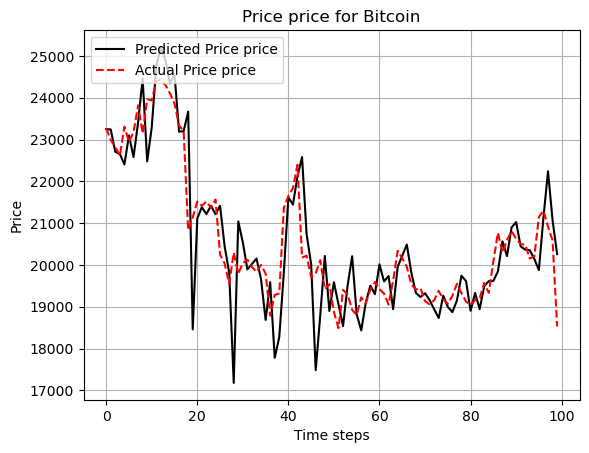

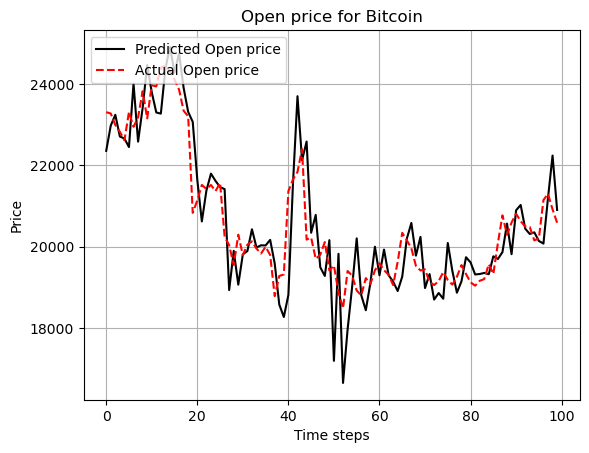

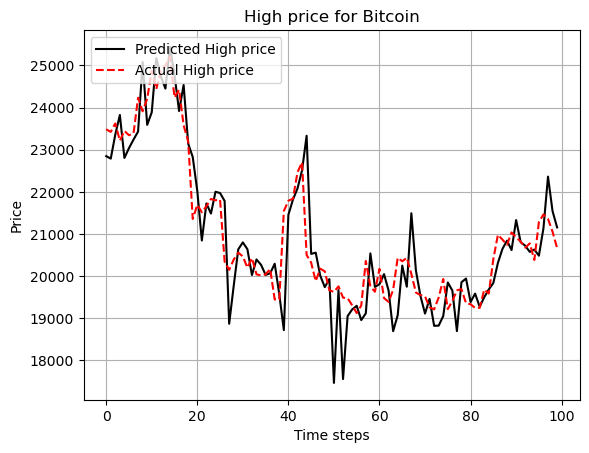

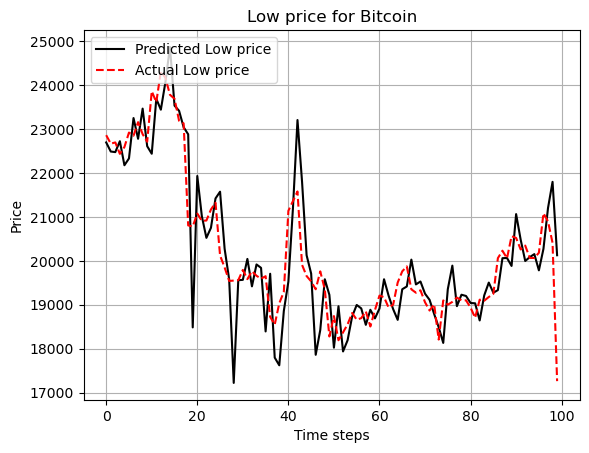

In [17]:
mape_computed=[]
predicted_btc_price_data = np.empty([0,dataset.shape[1]])

for idx in reversed(range(NUM_TEST)):
    
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]
    num_examples = train_dataset.shape[0]

    if idx == NUM_TEST - 1:
        model = hmm.GaussianHMM(n_components=opt_states, tol=0.0001, covariance_type='full', n_iter=NUM_ITERS, init_params='stmc')
    else:

    # Retuning the model by using the HMM paramters from the previous iterations as the prior

        model = hmm.GaussianHMM(n_components=opt_states, tol=0.0001, covariance_type='full', n_iter=NUM_ITERS, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior
        
    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    iters = 1
    past_likelihood = []

    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))

    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_btc_price_data = np.vstack((predicted_btc_price_data, dataset[idx + 1,:] + predicted_change))

mape = calc_mape(predicted_btc_price_data, np.flipud(dataset[range(NUM_TEST),:]))
names = ['Price','Open','High','Low']
mape_computed.append(mape)


if PLOT_TYPE:
    hdl_p = plt.plot(range(NUM_TEST), predicted_btc_price_data)
    plt.title('Predicted bitcoin prices')
    plt.legend(iter(hdl_p), ('Price','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(NUM_TEST),np.flipud(dataset[range(NUM_TEST),:]))
    plt.title('Actual bitcoin prices')
    plt.legend(iter(hdl_p), ('Price','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(NUM_TEST), predicted_btc_price_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(NUM_TEST),np.flipud(dataset[range(NUM_TEST),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.title(labels[i]+' price'+ ' for '+"Bitcoin")
        plt.grid(True)
        plt.legend(loc = 'upper left')        
if PLOT_SHOW:
    plt.show(block=False)

In [18]:
for name, mape in zip(names, mape):
    print("MAPE for {} : {}".format(name, mape), "which means predictions made by HMM are on average {:.2%} away from the actual values they were aiming for.".format(mape))

MAPE for Price : 0.028655336896298938 which means predictions made by HMM are on average 2.87% away from the actual values they were aiming for.
MAPE for Open : 0.028520640076534515 which means predictions made by HMM are on average 2.85% away from the actual values they were aiming for.
MAPE for High : 0.02570603875050898 which means predictions made by HMM are on average 2.57% away from the actual values they were aiming for.
MAPE for Low : 0.027635797716677183 which means predictions made by HMM are on average 2.76% away from the actual values they were aiming for.
